In [1]:
%pip install seaborn
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Install dependencies (run once per environment)
# If running in an offline environment, comment this out and ensure libs are installed
try:
    import vectorbt as vbt
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "vectorbt", "yfinance", "pandas", "numpy", "matplotlib", "seaborn"], check=False)
    import vectorbt as vbt

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Callable, Dict, List, Optional, Tuple

plt.style.use("seaborn-v0_8")
pd.options.display.max_columns = 200

# Global configuration
CONFIG = {
    "start": "2018-01-01",
    "end": None,  # up to latest
    "initial_capital": 100_000.0,
    "rebalance_freq": "A",  # "M" (monthly), "Q" (quarterly), "A" (annual)
    "execution_price": "close",  # "open" or "close" execution convention
    "fee_bps": 1.0,   # per-trade commission in basis points
    "slip_bps": 2.0,  # per-trade slippage in basis points
    "risk_free_rate": 0.0,
    "train_split": 0.6,  # ratio in (0,1) for train portion length
}

# Portfolio legs (example; replace with your own)
# id must be unique; target_weight must sum to 1.0 across legs
PORTFOLIO_LEGS = [
    {
        "id": "tqqq_trend",
        "symbol": "TQQQ",
        "strategy_name": "tqqq_3ema_macdv_aroon",
        "params": {  # Parameters from TQQQ_3EMA_MACDV_Aroon.ipynb
            "ema1": 12,
            "ema2": 89,
            "ema3": 125,
            "macd_fast": 25,
            "macd_slow": 30,
            "macd_signal": 85,
            "volume_threshold": 0.0,
            "aroon_length": 66,
        },
        "target_weight": 1.0,
    },
    # {
    #     "id": "gld_trend",
    #     "symbol": "GLD",
    #     "strategy_name": "sma_cross",
    #     "params": {
    #         "fast": 50,
    #         "slow": 200,
    #     },
    #     "target_weight": 0.0,
    # },
]




In [3]:
# Import data loader from lib (ensure project root is on sys.path)
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from lib.data_loader import load_data



In [4]:
# Import strategy/backtest/portfolio utilities from lib (reload to pick up local edits)
import importlib
import lib.strategies as _lib_strategies
import lib.legs as _lib_legs
import lib.portfolio as _lib_portfolio
import lib.metrics as _lib_metrics
importlib.reload(_lib_strategies)
importlib.reload(_lib_legs)
importlib.reload(_lib_portfolio)
importlib.reload(_lib_metrics)

from lib.strategies import STRATEGIES, register_strategy
from lib.legs import LegResult, backtest_leg
from lib.portfolio import PortfolioResult, rebalance_and_aggregate
from lib.metrics import (
    compute_metrics,
    plot_portfolio,
    build_metrics_table,
    build_split_metrics_tables,
)



ModuleNotFoundError: No module named 'lib.portfolio'

In [ ]:
# Note: Strategies are imported from lib/strategies.py (see cell 3)
# The correct TQQQ strategy implementation with OR logic is in lib/strategies.py
# This cell intentionally left blank - do not define strategies here as they will override the imports



In [ ]:
# Per-leg backtest functions are imported from lib.legs (see cell 3)
# backtest_leg and LegResult are available from the import
# The updated backtest_leg handles both:
#   - exposure Series (legacy strategies like sma_cross)  
#   - (entries, exits) tuples (new strategies like tqqq_3ema_macdv_aroon)



In [ ]:
# Portfolio aggregation functions are imported from lib.portfolio (see cell 3)
# rebalance_and_aggregate now uses vectorbt's Portfolio.from_signals with buy/sell signals
# No periodic rebalancing - positions are entered/exited based on strategy signals only



In [ ]:
# Metrics and plots

def compute_metrics(returns: pd.Series, rf: float = 0.0, freq_per_year: int = 252) -> Dict:
    ret = returns.fillna(0.0)
    cum = (1.0 + ret).prod() - 1.0
    ann = (1.0 + cum) ** (freq_per_year / max(1, len(ret))) - 1.0
    vol = ret.std() * np.sqrt(freq_per_year)
    excess = ret - (rf / freq_per_year)
    sharpe = np.nan if vol == 0 else (excess.mean() / ret.std()) * np.sqrt(freq_per_year)
    roll_max = (1.0 + ret).cumprod().cummax()
    underwater = (1.0 + ret).cumprod() / roll_max - 1.0
    max_dd = underwater.min()
    return {
        "total_return": float(cum),
        "cagr": float(ann),
        "vol": float(vol),
        "sharpe": float(sharpe),
        "max_drawdown": float(max_dd),
    }


def plot_portfolio(portfolio_df: pd.DataFrame, weights_df: pd.DataFrame, benchmark: Optional[pd.Series] = None) -> None:
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={"height_ratios": [2, 1, 1]})

    # Equity curves
    (portfolio_df["portfolio_equity"]).plot(ax=axes[0], label="Portfolio")
    if benchmark is not None:
        (benchmark / benchmark.iloc[0] * portfolio_df["portfolio_equity"].iloc[0]).plot(ax=axes[0], label="Benchmark")
    axes[0].set_title("Equity Curve")
    axes[0].legend()

    # Underwater
    eq = portfolio_df["portfolio_equity"]
    dd = eq / eq.cummax() - 1.0
    dd.plot(ax=axes[1], color="tab:red")
    axes[1].set_title("Drawdown")

    # Allocation drift
    weights_df.plot(ax=axes[2])
    axes[2].set_title("Weights")
    plt.tight_layout()
    plt.show()



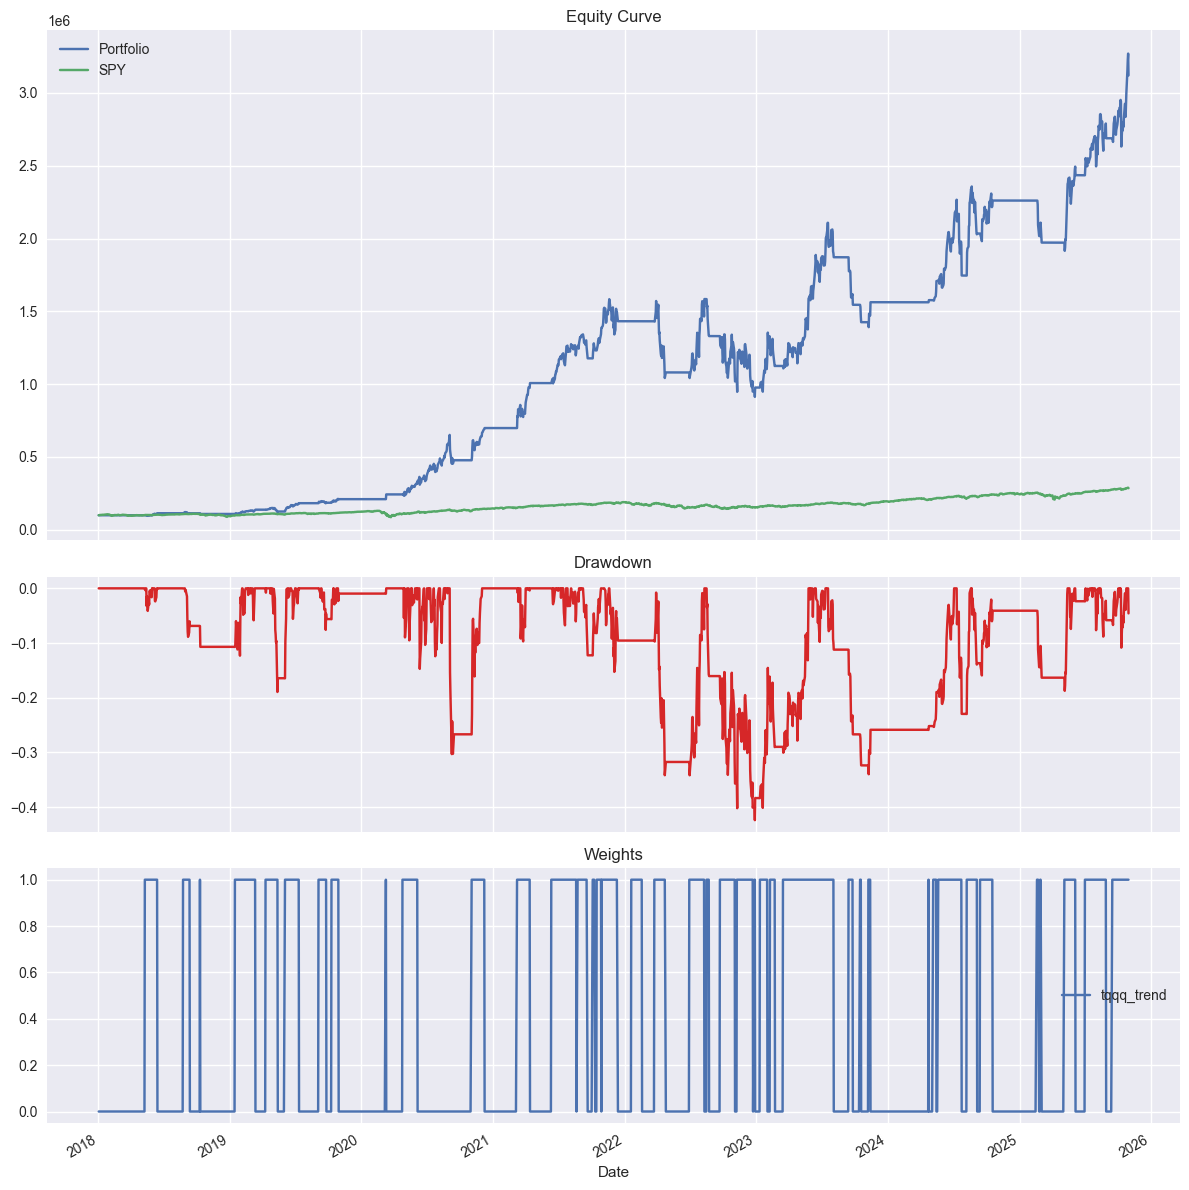

,portfolio_returns,portfolio_equity
Date,,
2025-10-24,0.031151,2.997323e+06
2025-10-27,0.053093,3.156461e+06
2025-10-28,0.022846,3.228575e+06
2025-10-29,0.012763,3.269782e+06
2025-10-30,-0.045767,3.120133e+06


In [ ]:
# Example run: build legs, backtest with vectorbt, combine with static weights

# 1) Load data
symbols = sorted({leg["symbol"] for leg in PORTFOLIO_LEGS})
DATA = load_data(symbols, CONFIG["start"], CONFIG["end"])  # dict: sym -> DF with open/high/low/close/volume

# 2) Generate exposures and backtest each leg
legs: Dict[str, LegResult] = {}
for leg in PORTFOLIO_LEGS:
    leg_id = leg["id"]
    sym = leg["symbol"]
    sname = leg["strategy_name"]
    params = leg.get("params", {})
    strat = STRATEGIES[sname]
    exposure = strat(DATA[sym], params)
    result = backtest_leg(sym, DATA[sym], exposure, CONFIG, leg_id, sname, params)
    legs[leg_id] = result

# 3) Aggregate legs into portfolio using buy/sell signals (no rebalancing)
weights_map = {leg["id"]: float(leg["target_weight"]) for leg in PORTFOLIO_LEGS}
portfolio = rebalance_and_aggregate(legs, weights_map, CONFIG["initial_capital"], config=CONFIG)
portfolio.legs = legs

# 5) Metrics and plots
metrics = compute_metrics(portfolio.portfolio_df["portfolio_returns"], CONFIG["risk_free_rate"])  # noqa: F841

# Optional: benchmark SPY
try:
    bm = yf.download("SPY", start=CONFIG["start"], end=CONFIG["end"], auto_adjust=True, progress=False)["Close"]
except Exception:
    bm = None

plot_portfolio(portfolio.portfolio_df, portfolio.weights_df, benchmark=bm if bm is not None and len(bm) > 0 else None)

portfolio.portfolio_df.tail()


In [ ]:
# Train/Validation/Full metrics tables (portfolio and legs)

# Determine train_end from ratio
split = float(CONFIG.get("train_split", 0.7))
split = min(max(split, 0.05), 0.95)
idx = portfolio.portfolio_df.index
split_pos = int(len(idx) * split)
train_end = idx[split_pos - 1] if split_pos > 0 else idx[0]

series_map = {"PORTFOLIO": portfolio.portfolio_df["portfolio_returns"].astype(float)}
# Create leg_result_map to enable period-specific portfolio creation for accurate metrics
leg_result_map = {}
portfolio_map = {}  # Portfolio aggregation doesn't have a Portfolio object, only legs do
for lid, l in portfolio.legs.items():
    series_map[f"LEG:{lid}"] = l.returns.astype(float)
    leg_result_map[f"LEG:{lid}"] = l  # Map leg names to LegResult objects
    # Pass portfolio object from leg if available (for vectorbt built-in metrics)
    if hasattr(l, 'portfolio') and l.portfolio is not None:
        portfolio_map[f"LEG:{lid}"] = l.portfolio

train_df, valid_df, full_df = build_split_metrics_tables(
    series_map,
    train_end=train_end,
    rf=float(CONFIG.get("risk_free_rate", 0.0)),
    freq_per_year=252,
    portfolio_map=portfolio_map if portfolio_map else None,
    leg_result_map=leg_result_map if leg_result_map else None,
)

# Formatting helper function (fallback if style doesn't work)
def format_metrics_df(df):
    """Format metrics DataFrame with proper number formatting"""
    df_fmt = df.copy()
    for col in ["total_return", "cagr", "vol", "max_drawdown"]:
        if col in df_fmt.columns:
            df_fmt[col] = df_fmt[col].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
    for col in ["sharpe", "sortino", "calmar"]:
        if col in df_fmt.columns:
            df_fmt[col] = df_fmt[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "N/A")
    return df_fmt

print("\n" + "="*80)
print(f"Train metrics (up to {train_end.date()}, {split:.0%} of data)")
print("="*80)
try:
    display(train_df.style.format({
        "total_return": lambda x: f"{x:.1%}" if pd.notna(x) else "N/A",
        "cagr": lambda x: f"{x:.2%}" if pd.notna(x) else "N/A",
        "vol": lambda x: f"{x:.2%}" if pd.notna(x) else "N/A",
        "sharpe": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
        "sortino": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
        "max_drawdown": lambda x: f"{x:.1%}" if pd.notna(x) else "N/A",
        "calmar": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
    }, na_rep="N/A"))
except AttributeError:
    display(format_metrics_df(train_df))

print("\n" + "="*80)
print(f"Validation metrics (after {train_end.date()}, {1-split:.0%} of data)")
print("="*80)
try:
    display(valid_df.style.format({
        "total_return": lambda x: f"{x:.1%}" if pd.notna(x) else "N/A",
        "cagr": lambda x: f"{x:.2%}" if pd.notna(x) else "N/A",
        "vol": lambda x: f"{x:.2%}" if pd.notna(x) else "N/A",
        "sharpe": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
        "sortino": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
        "max_drawdown": lambda x: f"{x:.1%}" if pd.notna(x) else "N/A",
        "calmar": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
    }, na_rep="N/A"))
except AttributeError:
    display(format_metrics_df(valid_df))

print("\n" + "="*80)
print("Full-period metrics")
print("="*80)
try:
    display(full_df.style.format({
        "total_return": lambda x: f"{x:.1%}" if pd.notna(x) else "N/A",
        "cagr": lambda x: f"{x:.2%}" if pd.notna(x) else "N/A",
        "vol": lambda x: f"{x:.2%}" if pd.notna(x) else "N/A",
        "sharpe": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
        "sortino": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
        "max_drawdown": lambda x: f"{x:.1%}" if pd.notna(x) else "N/A",
        "calmar": lambda x: f"{x:.2f}" if pd.notna(x) else "N/A",
    }, na_rep="N/A"))
except AttributeError:
    display(format_metrics_df(full_df))




Train metrics (up to 2022-09-09, 60% of data)


,total_return,cagr,vol,sharpe,sortino,max_drawdown,calmar
PORTFOLIO,1230.3%,73.71%,36.96%,1.68,2.71,-34.2%,2.16
LEG:tqqq_trend,1230.3%,122.52%,44.48%,2.02,3.13,-34.2%,3.58



Validation metrics (after 2022-09-09, 40% of data)


,total_return,cagr,vol,sharpe,sortino,max_drawdown,calmar
PORTFOLIO,134.6%,31.34%,43.79%,0.84,1.40,-34.0%,0.92
LEG:tqqq_trend,134.6%,48.42%,52.71%,1.01,1.57,-34.0%,1.42



Full-period metrics


,total_return,cagr,vol,sharpe,sortino,max_drawdown,calmar
PORTFOLIO,3020.1%,55.32%,39.83%,1.30,2.13,-42.4%,1.31
LEG:tqqq_trend,3020.1%,89.23%,47.94%,1.57,2.43,-42.4%,2.10
